# Next Frame Prediction with Convolutional LSTMs using Moving Mnist Dataset

İmporting Necessary Packages

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt
import torch
import cv2
import os

## Build a model

We create a model which take as input movies of shape
`(n_frames, width, height, channels)` and returns a movie
of identical shape.


In [ ]:
seq = keras.Sequential(
    [
        keras.Input(
            shape=(None, 40, 40, 1)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
                filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
            ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
seq.compile(loss="binary_crossentropy", optimizer="adadelta")

In [ ]:
device_name = tensorflow.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Getting Dataset into an array

In [ ]:
noisy_movies = np.zeros((1200, 20, 40, 40, 1), dtype=np.float)
shifted_movies = np.zeros((1200, 20, 40, 40, 1), dtype=np.float)
data = np.load('/content/drive/MyDrive/mnist_test_seq.npy')

for i in range(0,1200):
  print(i)
  for count in range(0,20):
    image = data[count][i]
    image = cv2.resize(image,(40,40))
    img = np.float64(image)
    shifted_movies[i,count,::,::,0]=img
    if np.random.randint(0, 2):
      noise_f = (-1) ** np.random.randint(0, 2)
      img += (noise_f * 0.1)
    noisy_movies[i,count,::,::,0]=img
    
noisy_movies[noisy_movies >= 1] = 1
shifted_movies[shifted_movies >= 1] = 1 

## Training

In [ ]:
epochs = 200
seq.fit(
    noisy_movies[:1000],
    shifted_movies[:1000],
    batch_size=10,
    epochs=epochs,
    verbose=2,
    validation_split=0.1
)


## Save and load model

In [ ]:
seq.save('/content/drive/MyDrive/saved_models/convlstm_movingmnist_resized.h5')

In [ ]:
seq = keras.models.load_model("/content/drive/MyDrive/saved_models/convlstm_movingmnist_resized.h5")

## Test the model on one movie

Feed it with the 10 positions and then
predict the new positions.


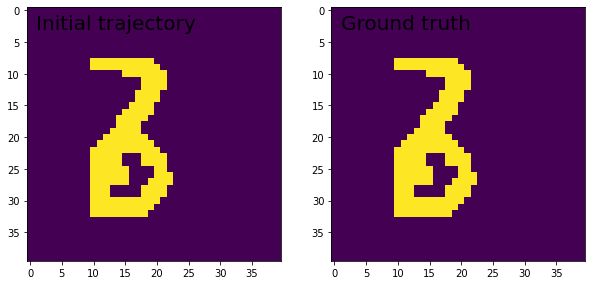

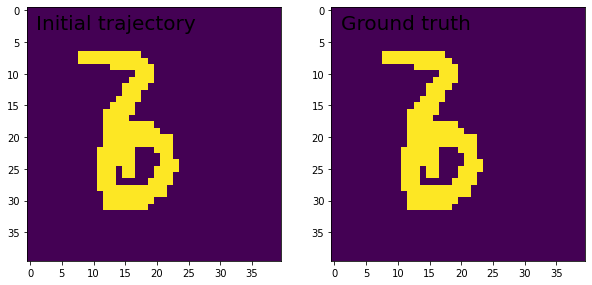

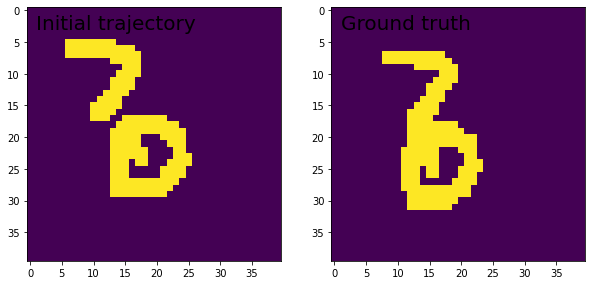

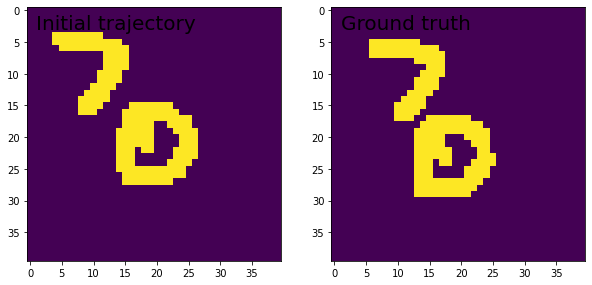

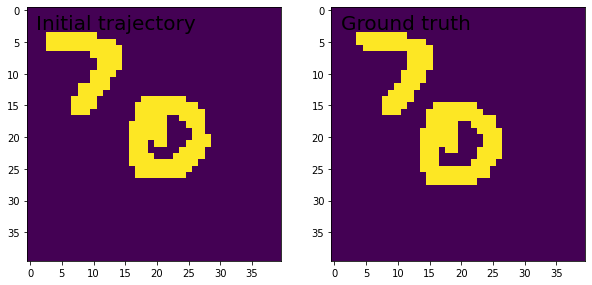

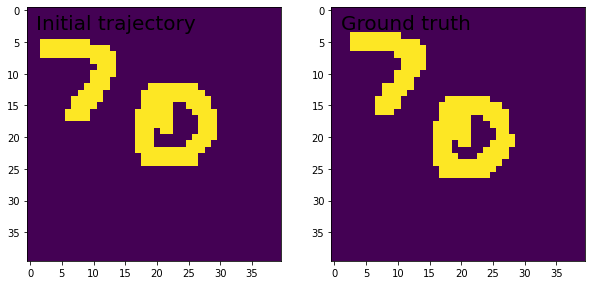

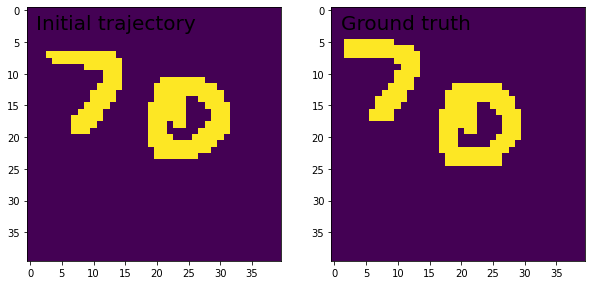

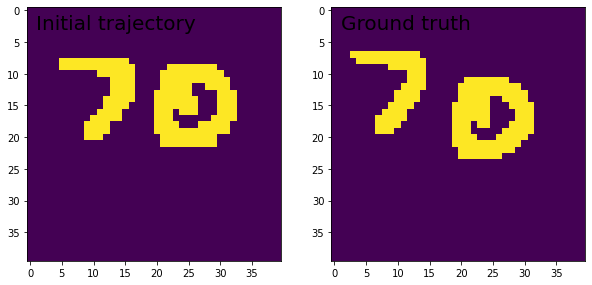

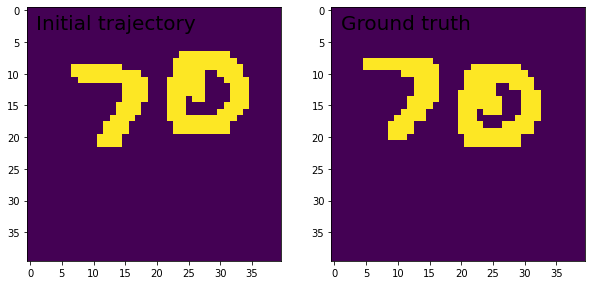

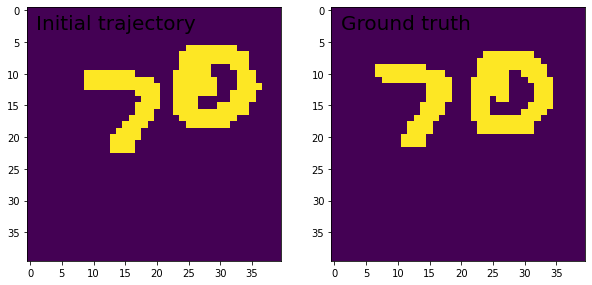

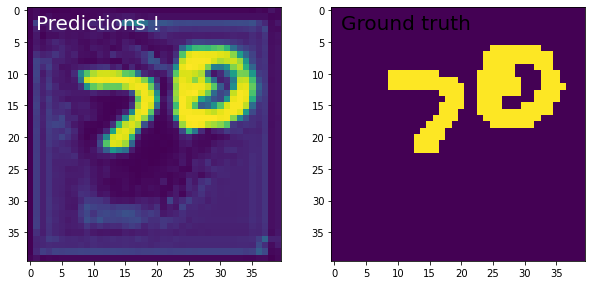

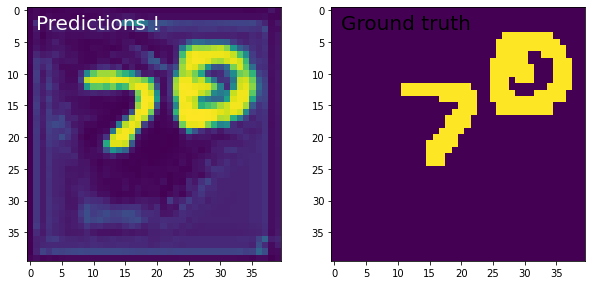

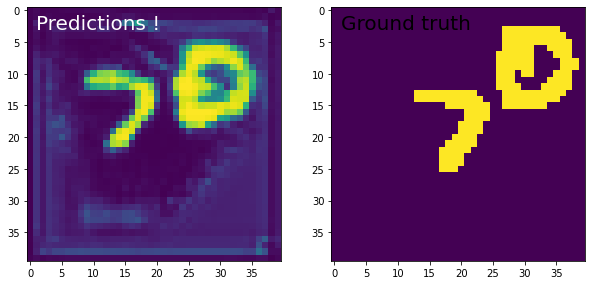

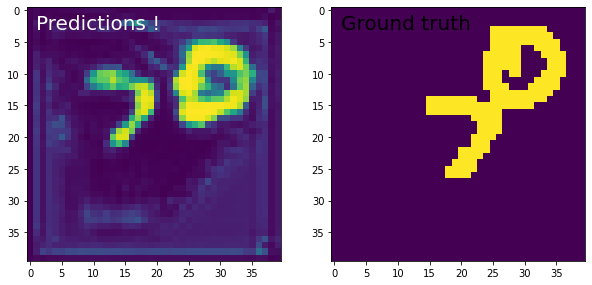

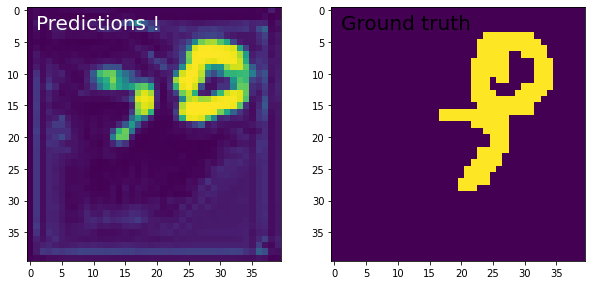

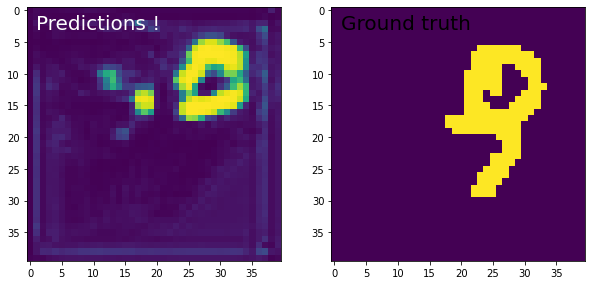

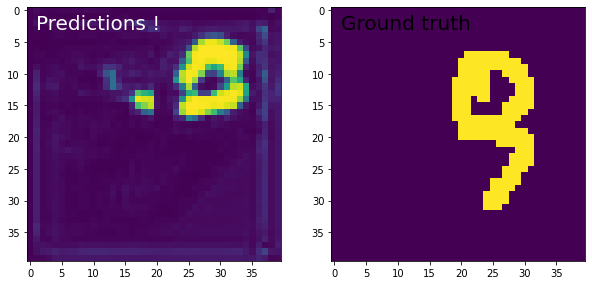

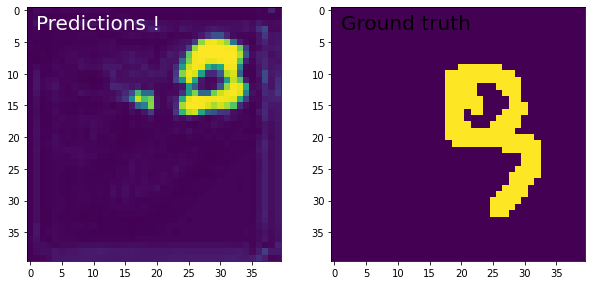

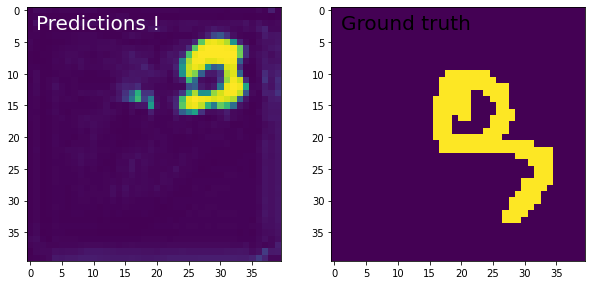

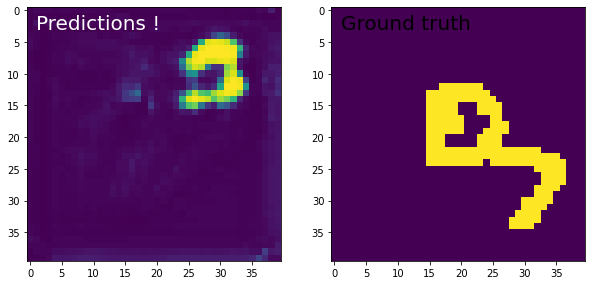

In [ ]:
movie_index = 1004
track = noisy_movies[movie_index][:10, ::, ::, ::]

for j in range(20):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[movie_index][::, ::, ::, ::]
for i in range(20):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 10:
        ax.text(1, 3, "Predictions !", fontsize=20, color="w")
    else:
        ax.text(1, 3, "Initial trajectory", fontsize=20)

    toplot = track[i, ::, ::, 0]
    if i>=10:
      toplot_predict=toplot*255
      cv2.imwrite('/content/drive/MyDrive/conv_lstm_mnist_predictions/1004_resized_10/%i_prediction.png' % (i-10),toplot_predict)
    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, "Ground truth", fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[movie_index][i - 1, ::, ::, 0]
    if i>=10:
      toplot_truth=toplot*255
      cv2.imwrite('/content/drive/MyDrive/conv_lstm_mnist_predictions/1004_resized_10/%i_ground_truth.png' % (i-10),toplot_truth)
    plt.imshow(toplot)


<Figure size 720x1080 with 0 Axes>

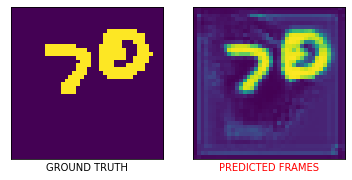

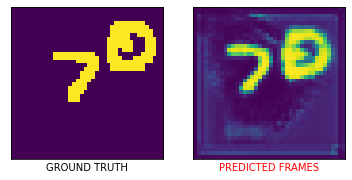

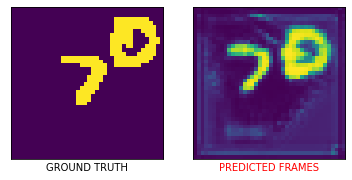

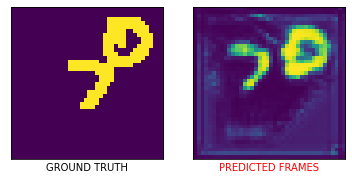

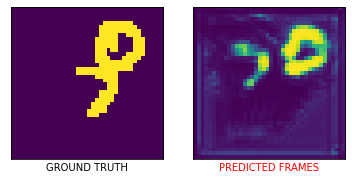

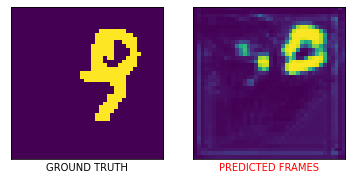

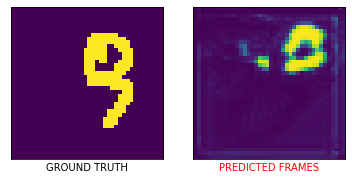

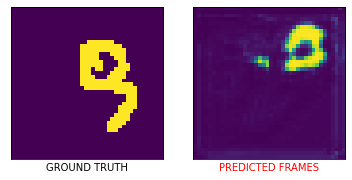

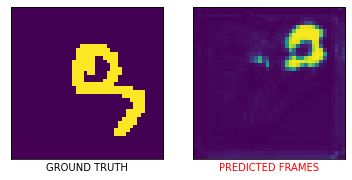

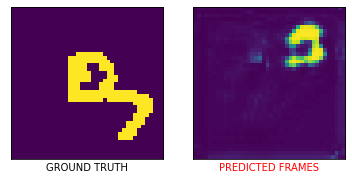

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Plot comparison
fig=plt.figure(figsize=(10, 15))
for i in range(10):
  ground_truth = Image.open('/content/drive/MyDrive/conv_lstm_mnist_predictions/1004_resized_10/%i_ground_truth.png' % (i))
  predictions = Image.open('/content/drive/MyDrive/conv_lstm_mnist_predictions/1004_resized_10/%i_prediction.png' % (i))
  f, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(ground_truth)
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_xlabel('GROUND TRUTH')
  ax2.imshow(predictions)
  ax2.set_xticks([])
  ax2.set_yticks([])
  ax2.set_xlabel('PREDICTED FRAMES', color='r')
  f.savefig('/content/drive/MyDrive/conv_lstm_mnist_predictions/1004_resized_10/comparison'+str(i)+'.png', tight=True)

## Creating video from predicted frames

In [ ]:
import cv2
import numpy as np
from cv2 import VideoWriter, VideoWriter_fourcc
width = 432
height = 288
width2 = 40
height2 = 40
FPS = 5 #Saniyedeki frame sayısı azaltılarak saniye artırılabilir.
fourcc = VideoWriter_fourcc(*'mp4v')
name='/content/drive/MyDrive/predicted_videos/convlstmmnist_comparison.mp4'
name2='/content/drive/MyDrive/predicted_videos/convlstmmnist_predicted.mp4'
video = VideoWriter(name, fourcc, float(FPS), (width, height))
video2 = VideoWriter(name2, fourcc, float(FPS), (width2, height2))
for i in range(10):
  img = cv2.imread('/content/drive/MyDrive/conv_lstm_mnist_predictions/1004_resized_10/comparison'+str(i)+'.png')
  video.write(img)
  img2 = cv2.imread('/content/drive/MyDrive/conv_lstm_mnist_predictions/1004_resized_10/%i_prediction.png' % (i))
  video2.write(img2)
video.release()
video2.release()